In [9]:
import os
import glob
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.applications import VGG19
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy

In [11]:
root_dir = "/Users/dhrutipurushotham/Documents/Projects/BreastCancerDetection/Dataset_BUSI_with_GT"

# Function to get files from a class directory (excluding masks)
def get_files(root_dir, class_name):
    path = os.path.join(root_dir, class_name)
    files = glob.glob(os.path.join(path, '*'))
    return [f for f in files if 'mask' not in f]

# Function to load the dataset
def load_dataset():
    benign = get_files(root_dir, 'benign')
    malignant = get_files(root_dir, 'malignant')
    normal = get_files(root_dir, 'normal')

    df1 = pd.DataFrame({'path': benign, 'class': 'benign'})
    df2 = pd.DataFrame({'path': malignant, 'class': 'malignant'})
    df3 = pd.DataFrame({'path': normal, 'class': 'normal'})

    df = pd.concat([df1, df2, df3], axis=0)
    df = df.sample(frac=1.0).reset_index(drop=True)
    return df

# Load the dataset
df = load_dataset()
print(df.head())

                                                path   class
0  /Users/dhrutipurushotham/Documents/Projects/Br...  benign
1  /Users/dhrutipurushotham/Documents/Projects/Br...  benign
2  /Users/dhrutipurushotham/Documents/Projects/Br...  benign
3  /Users/dhrutipurushotham/Documents/Projects/Br...  benign
4  /Users/dhrutipurushotham/Documents/Projects/Br...  benign


In [13]:
def split_data(df):
    total = df.shape[0]
    train_df = df.iloc[:int(0.7 * total)]
    test_df = df.iloc[int(0.7 * total):int(0.85 * total)]
    valid_df = df.iloc[int(0.85 * total):]
    return train_df, test_df, valid_df

In [15]:
def create_generators(train_df, test_df, valid_df, target_size=(224, 224)):
    datagen = ImageDataGenerator(rescale=1/255)

    train_gen = datagen.flow_from_dataframe(
        train_df, x_col="path", y_col="class", target_size=target_size,
        class_mode="categorical", batch_size=32, seed=42, shuffle=True
    )

    test_gen = datagen.flow_from_dataframe(
        test_df, x_col="path", y_col="class", target_size=target_size,
        class_mode="categorical", batch_size=1, seed=42, shuffle=True
    )

    valid_gen = datagen.flow_from_dataframe(
        valid_df, x_col="path", y_col="class", target_size=target_size,
        class_mode="categorical", batch_size=1, seed=42, shuffle=True
    )

    return train_gen, test_gen, valid_gen

In [17]:
def build_model(input_shape=(224, 224, 3), num_classes=3):
    base_model = VGG19(include_top=False, input_shape=input_shape, pooling='max', weights='imagenet')
    base_model.trainable = False

    model = Sequential([
        base_model,
        Flatten(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer=Adam(learning_rate=1e-4),
                  loss=CategoricalCrossentropy(),
                  metrics=['accuracy'])

    return model

In [21]:
def plot_training(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(8, 6))
    plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
    plt.title('Training vs Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

In [23]:
def evaluate(model, eval_gen):
    index = random.randint(0, len(eval_gen) - 1)
    image, label = eval_gen[index]
    prediction = model.predict(image)

    true_label = np.argmax(label[0])
    predicted_label = np.argmax(prediction[0])

    print(f'True label: {true_label}')
    print(f'Predicted label: {predicted_label}')

    plt.figure(figsize=(6, 6))
    plt.imshow(image[0])
    plt.axis('off')
    plt.title(f'Predicted: {predicted_label} | Actual: {true_label}')
    plt.show()


Found 546 validated image filenames belonging to 3 classes.
Found 117 validated image filenames belonging to 3 classes.
Found 117 validated image filenames belonging to 3 classes.


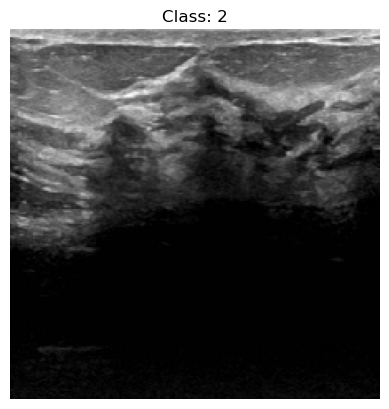

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 19s 0us/step


/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 126s 7s/step - accuracy: 0.3990 - loss: 1.4714 - val_accuracy: 0.3419 - val_loss: 1.0496
Epoch 2/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 84s 5s/step - accuracy: 0.4109 - loss: 1.3418 - val_accuracy: 0.6068 - val_loss: 0.9624
Epoch 3/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 93s 5s/step - accuracy: 0.5157 - loss: 1.1281 - val_accuracy: 0.6496 - val_loss: 0.9317
Epoch 4/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 88s 5s/step - accuracy: 0.5522 - loss: 1.0123 - val_accuracy: 0.6667 - val_loss: 0.8995
Epoch 5/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 94s 5s/step - accuracy: 0.5258 - loss: 1.0186 - val_accuracy: 0.7009 - val_loss: 0.8935
Epoch 6/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 91s 5s/step - accuracy: 0.5615 - loss: 0.9468 - val_accuracy: 0.7094 - val_loss: 0.8814
Epoch 7/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 97s 5s/step - accuracy: 0.6037 - loss: 0.8867 - val_accuracy: 0.7094 - val_loss: 0.8652
Epoch 8/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 100s 6s/step - accuracy: 0.6308 - loss: 0.8715 - val_accuracy: 0.6667 - val_los

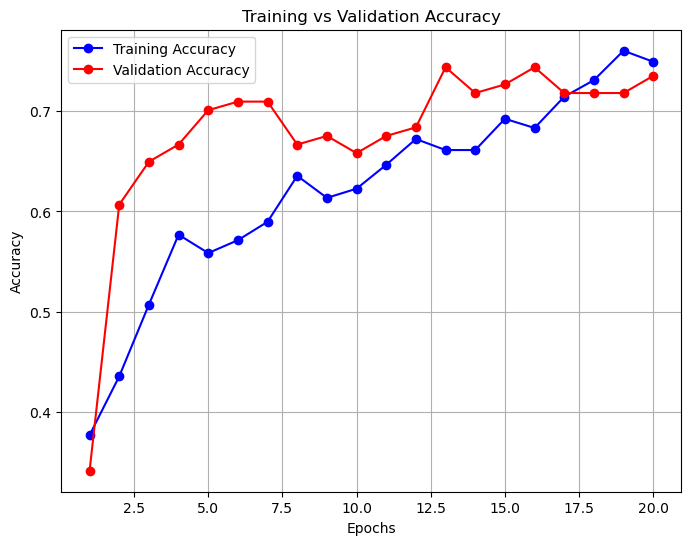

Model saved to /Users/dhrutipurushotham/Documents/Projects/BreastCancerDetection/model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step
True label: 0
Predicted label: 0


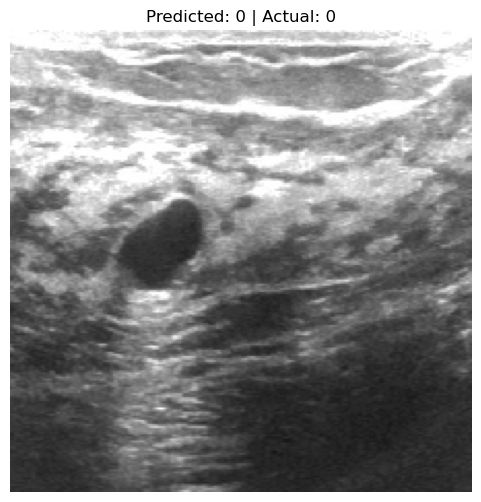

In [29]:
if __name__ == "__main__":
    root_dir = "/Users/dhrutipurushotham/Documents/Projects/BreastCancerDetection/Dataset_BUSI_with_GT"
    df = load_dataset()
    train_df, test_df, valid_df = split_data(df)
    train_gen, test_gen, valid_gen = create_generators(train_df, test_df, valid_df)

    # Preview a sample image
    sample_img, sample_label = next(train_gen)
    plt.imshow(sample_img[0])
    plt.title(f"Class: {np.argmax(sample_label[0])}")
    plt.axis('off')
    plt.show()

    # Build, Train, and Save the model
    model = build_model()
    history = model.fit(train_gen, epochs=20, validation_data=test_gen)
    plot_training(history)

    model_path = '/Users/dhrutipurushotham/Documents/Projects/BreastCancerDetection/model.keras'
    model.save(model_path)
    print(f"Model saved to {model_path}")

    # Evaluate on a random sample
    evaluate(model, valid_gen)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
True label: 1
Predicted label: 1


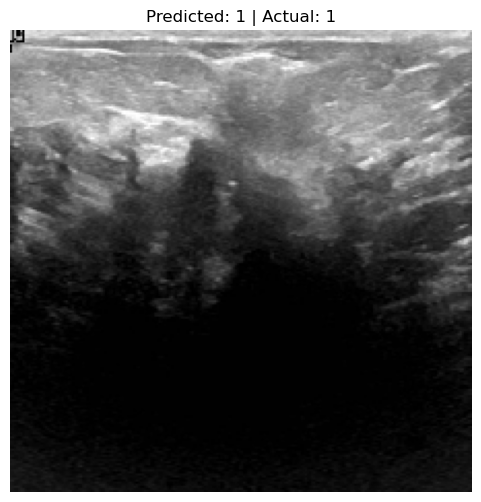

In [31]:
evaluate(model, valid_gen)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
True label: 1
Predicted label: 1


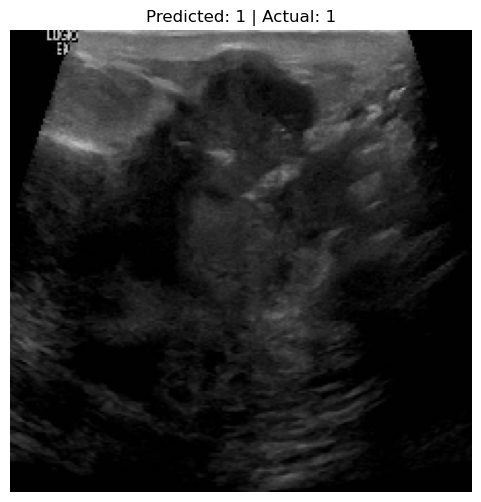

In [33]:
evaluate(model, valid_gen)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
True label: 2
Predicted label: 2


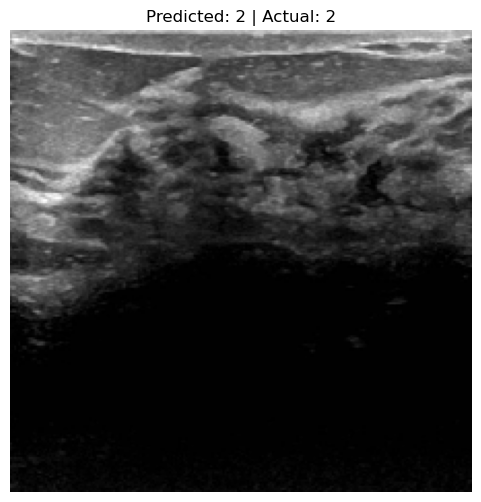

In [36]:
evaluate(model, valid_gen)